# Using SHAP to debug a PyTorch Image Regression Model

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob 
import random 

from PIL import Image
import cv2

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import shap
from sklearn.metrics import mean_squared_error

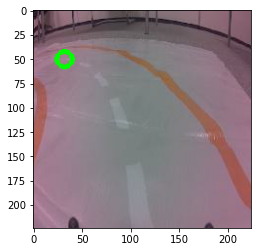

In [20]:
#Load example image
name = "32_50_c78164b4-40d2-11ed-a47b-a46bb6070c92.jpg"
x = int(name.split("_")[0])
y = int(name.split("_")[1])

img = Image.open("../data/room_1/" + name)
img = np.array(img)
cv2.circle(img, (x, y), 8, (0, 255, 0), 3)

plt.imshow(img)

path = "/Users/conorosullivan/Google Drive/My Drive/Medium/shap_imagedata/example.png"
plt.savefig(path, bbox_inches='tight',facecolor='w', edgecolor='w', transparent=False,dpi=200)

# Model Training

In [5]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, paths, transform):

        self.transform = transform
        self.paths = paths

    def __getitem__(self, idx):
        """Get image and target (x, y) coordinates"""

        # Read image
        path = self.paths[idx]
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = Image.fromarray(image)

        # Transform image
        image = self.transform(image)
        
        # Get target
        target = self.get_target(path)
        target = torch.Tensor(target)

        return image, target
    
    def get_target(self,path):
        """Get the target (x, y) coordinates from path"""

        name = os.path.basename(path)
        items = name.split('_')
        x = items[0]
        y = items[1]

        # Scale between -1 and 1
        x = 2.0 * (int(x)/ 224 - 0.5) # -1 left, +1 right
        y = 2.0 * (int(y) / 244 -0.5)# -1 top, +1 bottom

        return [x, y]

    def __len__(self):
        return len(self.paths)


In [6]:
TRANSFORMS = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

all_rooms = False # Change if you want to use all the data

paths = glob.glob('../data/room_1/*')
if all_rooms:
    paths = paths + glob.glob('../data/room_2/*') + glob.glob('../data/room_3/*')

# Shuffle the paths
random.shuffle(paths)

# Create a datasets for training and validation
split = int(0.8 * len(paths))
train_data = ImageDataset(paths[:split], TRANSFORMS)
valid_data = ImageDataset(paths[split:], TRANSFORMS)

# Prepare data for Pytorch model
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=valid_data.__len__())

print(train_data.__len__())
print(valid_data.__len__())

1217
305


In [63]:
output_dim = 2 # x, y
device = torch.device('cpu') # or 'cuda' if you have a GPU

# RESNET 18
model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, output_dim)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters())

In [64]:
name = "direction_model_1" # Change this to save a new model

# Train the model
min_loss = np.inf
for epoch in range(10):

    model = model.train()
    for images, target in iter(train_loader):

        images = images.to(device)
        target = target.to(device)
        
        # Zero gradients of parameters
        optimizer.zero_grad()  

        # Execute model to get outputs
        output = model(images)

        # Calculate loss
        loss = torch.nn.functional.mse_loss(output, target)

        # Run backpropogation to accumulate gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Calculate validation loss
    model = model.eval()

    images, target = next(iter(valid_loader))
    images = images.to(device)
    target = target.to(device)

    output = model(images)
    valid_loss = torch.nn.functional.mse_loss(output, target)

    print("Epoch: {}, Validation Loss: {}".format(epoch, valid_loss.item()))
    
    if valid_loss < min_loss:
        print("Saving model")
        torch.save(model, '../models/{}.pth'.format(name))

        min_loss = valid_loss

Epoch: 0, Validation Loss: 0.0743454173207283
Saving model
Epoch: 1, Validation Loss: 0.004585665185004473
Saving model
Epoch: 2, Validation Loss: 0.006513293832540512
Epoch: 3, Validation Loss: 0.012413629330694675
Epoch: 4, Validation Loss: 0.01125442422926426
Epoch: 5, Validation Loss: 0.01828325167298317
Epoch: 6, Validation Loss: 0.011874272488057613
Epoch: 7, Validation Loss: 0.003963700495660305
Saving model
Epoch: 8, Validation Loss: 0.004757680464535952
Epoch: 9, Validation Loss: 0.014229067601263523


# Model Evaluation

In [9]:
def model_evaluation(loaders,labels,save_path = None):

    """Evaluate direction models with mse and scatter plots
        loaders: list of data loaders
        labels: list of labels for plot title"""

    n = len(loaders)
    fig, axs = plt.subplots(1, n, figsize=(7*n, 6))
    fig.patch.set_facecolor('xkcd:white')

    # Evalution metrics
    for i, loader in enumerate(loaders):

        # Load all data
        images, target = next(iter(loader))
        images = images.to(device)
        target = target.to(device)

        output=model(images)

        # Get x predictions
        x_pred=output.detach().cpu().numpy()[:,0]
        x_target=target.cpu().numpy()[:,0]

        # Calculate MSE
        mse = mean_squared_error(x_target, x_pred)

        # Plot predcitons
        axs[i].scatter(x_target,x_pred)
        axs[i].plot([-1, 1], 
                [-1, 1], 
                color='r', 
                linestyle='-', 
                linewidth=2)

        axs[i].set_ylabel('Predicted x', size =15)
        axs[i].set_xlabel('Actual x', size =15)
        axs[i].set_title("{0} MSE: {1:.4f}".format(labels[i], mse),size = 18)

    if save_path != None:
        fig.savefig(save_path)


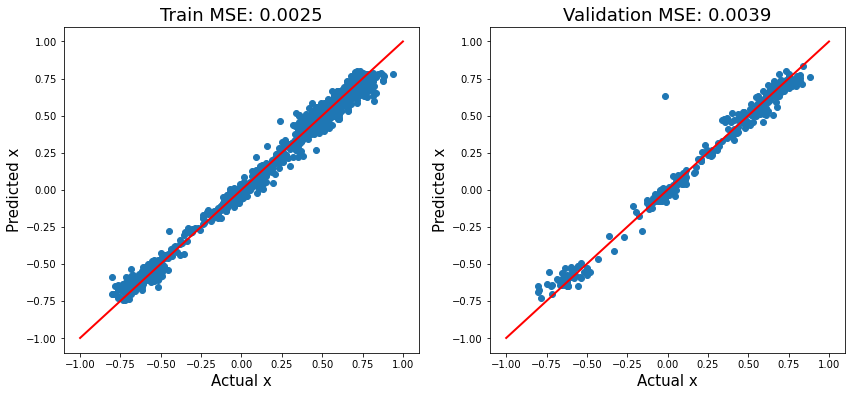

In [10]:
# Load saved model 
model = torch.load('../models/direction_model_1.pth')
model.eval()
model.to(device)

# Create new loader for all data
train_loader = DataLoader(train_data, batch_size=train_data.__len__())

# Evaluate model on training and validation set
loaders = [train_loader,valid_loader]
labels = ["Train","Validation"]

path = "/Users/conorosullivan/Google Drive/My Drive/Medium/shap_imagedata/evaluation_1.png"
model_evaluation(loaders,labels,save_path=path)

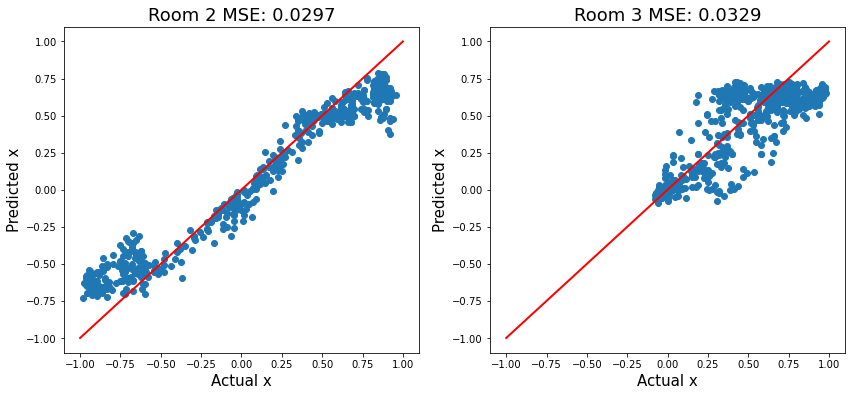

In [11]:
# Evaluate on data for additonal rooms
room_2 = glob.glob('../data/room_2/*')
room_3 = glob.glob('../data/room_3/*')

room_2_data = ImageDataset(room_2, TRANSFORMS)
room_3_data = ImageDataset(room_3, TRANSFORMS)

room_2_loader = DataLoader(room_2_data, batch_size=room_2_data.__len__())
room_3_loader = DataLoader(room_3_data, batch_size=room_3_data.__len__())

# Evaluate model on training and validation set
loaders = [room_2_loader ,room_3_loader]
labels = ["Room 2","Room 3"]

path = "/Users/conorosullivan/Google Drive/My Drive/Medium/shap_imagedata/evaluation_2.png"
model_evaluation(loaders,labels, save_path=path)

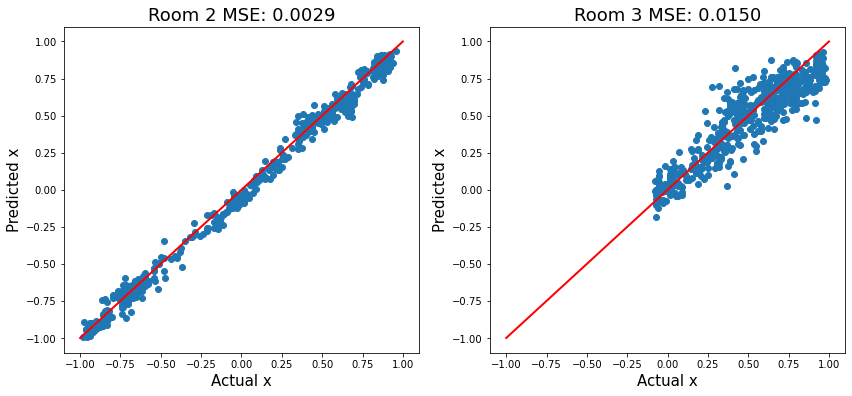

In [12]:
# Load saved model 
model = torch.load('../models/direction_model_2.pth')

model.eval()
model.to(device)

# Evaluate model on training and validation set
loaders = [room_2_loader ,room_3_loader]
labels = ["Room 2","Room 3"]

path = "/Users/conorosullivan/Google Drive/My Drive/Medium/shap_imagedata/evaluation_3.png"
model_evaluation(loaders,labels,save_path=path)

# SHAP Explainer 

In [7]:
# Load saved model 
model = torch.load('../models/direction_model_1.pth') #change for different model
model.eval()

# Use CPU
device = torch.device('cpu')
model = model.to(device)

In [8]:
#Load 100 images for background
shap_loader = DataLoader(train_data, batch_size=100, shuffle=True)
background, _ = next(iter(shap_loader))
background = background.to(device)

#Create SHAP explainer 
explainer = shap.DeepExplainer(model, background)

The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


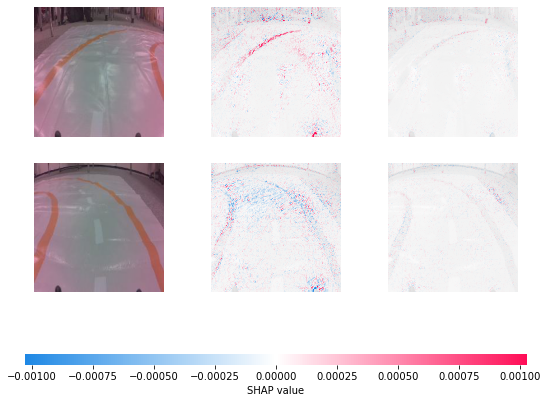

In [11]:
# Load test images of right and left turn
paths = glob.glob('../data/room_1/*')
test_images = [Image.open(paths[0]), Image.open(paths[3])]
test_images = np.array(test_images)

test_input = [TRANSFORMS(img) for img in test_images]
test_input = torch.stack(test_input).to(device)

# Get SHAP values
shap_values = explainer.shap_values(test_input)

# Reshape shap values and images for plotting
shap_numpy = list(np.array(shap_values).transpose(0,1,3,4,2))
test_numpy = np.array([np.array(img) for img in test_images])

shap.image_plot(shap_numpy, test_numpy,show=False)

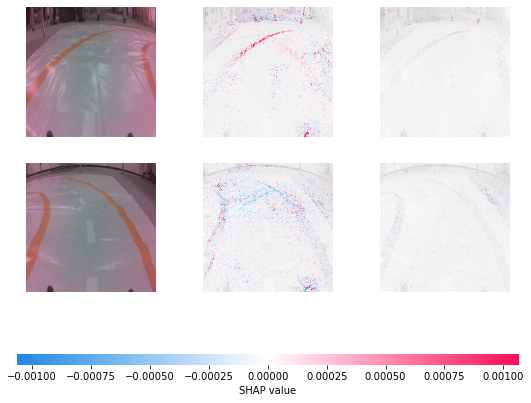

In [12]:
# Using gradient explainer
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_input)

shap_numpy = list(np.array(shap_values).transpose(0,1,3,4,2))

shap.image_plot(shap_numpy, test_numpy)

The input object of type 'JpegImageFile' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'JpegImageFile', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


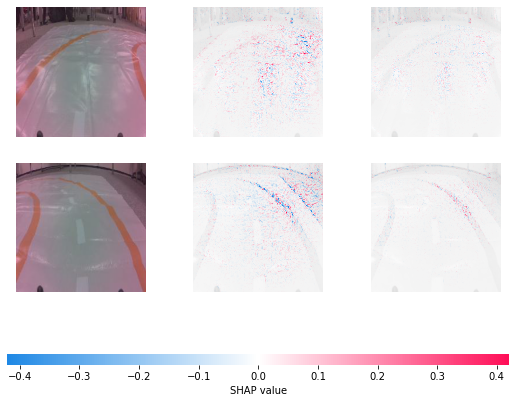

In [13]:
# Load model trained on room 1, 2 and 3
model = torch.load('../models/direction_model_2.pth') #change for different model

# Use CPU
device = torch.device('cpu')
model = model.to(device)

#Load 100 images for background
shap_loader = DataLoader(train_data, batch_size=100, shuffle=True)
background, _ = next(iter(shap_loader))
background = background.to(device)

#Create SHAP explainer 
explainer = shap.DeepExplainer(model, background)

# Load test images of right and left turn
paths = glob.glob('../data/room_1/*')
test_images = [Image.open(paths[0]), Image.open(paths[3])]
test_images = np.array(test_images)

# Transform images
test_input = [TRANSFORMS(img) for img in test_images]
test_input = torch.stack(test_input).to(device)

# Get SHAP values
shap_values = explainer.shap_values(test_input)

# Reshape shap values and images for plotting
shap_numpy = list(np.array(shap_values).transpose(0,1,3,4,2))
test_numpy = np.array([np.array(img) for img in test_images])

shap.image_plot(shap_numpy, test_numpy,show=False)
plt.savefig("/Users/conorosullivan/Google Drive/My Drive/Medium/shap_imagedata/shap_plot_2.png",facecolor='white',dpi=300,bbox_inches='tight')

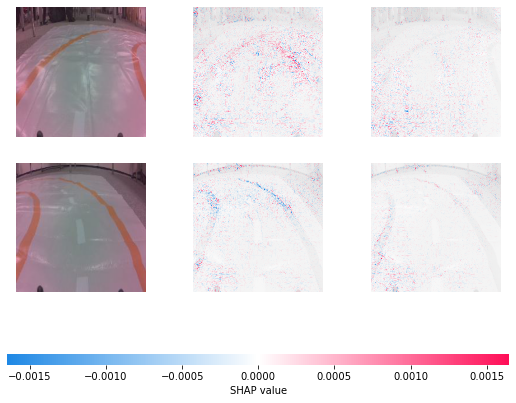

In [14]:
# Using Gradient Explainer
e = shap.GradientExplainer(model, background)
shap_values = e.shap_values(test_input)

shap_numpy = list(np.array(shap_values).transpose(0,1,3,4,2))
test_numpy = np.array([np.array(img) for img in test_images])

shap.image_plot(shap_numpy, test_numpy)